## Binary Classification Prediction
Date: Apr 2, 2019

Desc: In this notebook, several classification models are generated to predict the amount of purchases on Black Friday for each UserID. Before running any analysis, we first aggregate the purchase amount by UserID.

## 1. Import dataset

In [1]:
# import packages 
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt

%matplotlib inline

sales = pd.read_csv('BlackFriday.csv')
print(sales.info())
sales.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Product_Category_2            370591 non-null float64
Product_Category_3            164278 non-null float64
Purchase                      537577 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 49.2+ MB
None


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [2]:
gb = sales.groupby(["User_ID"])
sales["PurchaseSum"] = gb["Purchase"].transform("sum")
sales.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,PurchaseSum
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370,333481
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200,333481
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422,333481
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057,333481
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969,810353


In [3]:
# check if the sum is success
filter1 = sales['User_ID'] == 1000001
sales2 = sales[filter1]
sales2.head(10)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,PurchaseSum
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370,333481
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200,333481
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422,333481
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057,333481
39180,1000001,P00085942,F,0-17,10,A,2,0,2,4.0,8.0,12842,333481
78144,1000001,P00102642,F,0-17,10,A,2,0,4,8.0,9.0,2763,333481
78145,1000001,P00110842,F,0-17,10,A,2,0,1,2.0,5.0,11769,333481
78146,1000001,P00004842,F,0-17,10,A,2,0,3,4.0,12.0,13645,333481
116848,1000001,P00117942,F,0-17,10,A,2,0,5,15.0,NaN,8839,333481
116849,1000001,P00258742,F,0-17,10,A,2,0,5,NaN,NaN,6910,333481


In [4]:
# for each userID, only keep one record
sales.drop_duplicates(subset=['User_ID'], keep='first', inplace=True)
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5891 entries, 0 to 243533
Data columns (total 13 columns):
User_ID                       5891 non-null int64
Product_ID                    5891 non-null object
Gender                        5891 non-null object
Age                           5891 non-null object
Occupation                    5891 non-null int64
City_Category                 5891 non-null object
Stay_In_Current_City_Years    5891 non-null object
Marital_Status                5891 non-null int64
Product_Category_1            5891 non-null int64
Product_Category_2            4097 non-null float64
Product_Category_3            1914 non-null float64
Purchase                      5891 non-null int64
PurchaseSum                   5891 non-null int64
dtypes: float64(2), int64(6), object(5)
memory usage: 644.3+ KB


In [5]:
# convert PurchaseSum to categorical variables
sales['PurchaseSum'].median()

512612.0

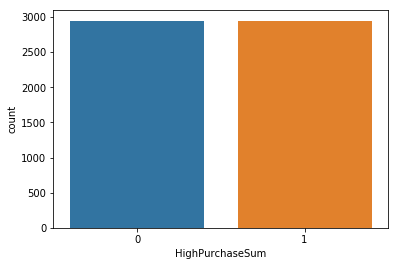

In [6]:
# convert Purchase to a binary variable by dividing at its mean value
sales['HighPurchaseSum'] = sales['PurchaseSum'].apply(lambda x: 0 if x < 512612 else 1)

sns.countplot(sales['HighPurchaseSum'])

In [7]:
print(sales.info())
sales.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5891 entries, 0 to 243533
Data columns (total 14 columns):
User_ID                       5891 non-null int64
Product_ID                    5891 non-null object
Gender                        5891 non-null object
Age                           5891 non-null object
Occupation                    5891 non-null int64
City_Category                 5891 non-null object
Stay_In_Current_City_Years    5891 non-null object
Marital_Status                5891 non-null int64
Product_Category_1            5891 non-null int64
Product_Category_2            4097 non-null float64
Product_Category_3            1914 non-null float64
Purchase                      5891 non-null int64
PurchaseSum                   5891 non-null int64
HighPurchaseSum               5891 non-null int64
dtypes: float64(2), int64(7), object(5)
memory usage: 850.4+ KB
None


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,PurchaseSum,HighPurchaseSum
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370,333481,0
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969,810353,1
5,1000003,P00193542,M,26-35,15,A,3,0,1,2.0,NaN,15227,341635,0
6,1000004,P00184942,M,46-50,7,B,2,1,1,8.0,17.0,19215,205987,0
9,1000005,P00274942,M,26-35,20,A,1,1,8,NaN,NaN,7871,821001,1


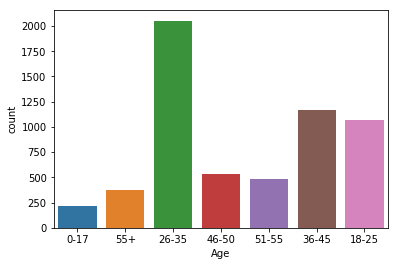

In [8]:
# you may create a distribution plot for every variable
sns.countplot(sales['Age'])

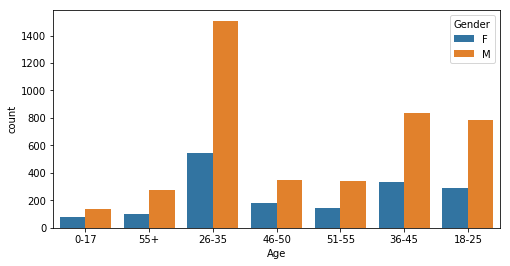

In [9]:
# you may also create distribution plot for two dimensions
fig1, ax1 = plt.subplots(figsize = (8,4))
sns.countplot(sales['Age'], hue = sales['Gender'])

In [10]:
# convert Age, City_Category, Stay_In_Current_City_Years to dummy variables

sales['Gender'] = sales.Gender.map({'F':0,'M':1})

sales_Age = pd.get_dummies(sales['Age'])
sales_City = pd.get_dummies(sales['City_Category'])
sales_Year = pd.get_dummies(sales['Stay_In_Current_City_Years'])

# Join the dummy variables to the main dataframe
sales_new = pd.concat([sales, sales_Age, sales_City, sales_Year], axis=1)

In [11]:
print(sales_new.info())
sales_new.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5891 entries, 0 to 243533
Data columns (total 29 columns):
User_ID                       5891 non-null int64
Product_ID                    5891 non-null object
Gender                        5891 non-null int64
Age                           5891 non-null object
Occupation                    5891 non-null int64
City_Category                 5891 non-null object
Stay_In_Current_City_Years    5891 non-null object
Marital_Status                5891 non-null int64
Product_Category_1            5891 non-null int64
Product_Category_2            4097 non-null float64
Product_Category_3            1914 non-null float64
Purchase                      5891 non-null int64
PurchaseSum                   5891 non-null int64
HighPurchaseSum               5891 non-null int64
0-17                          5891 non-null uint8
18-25                         5891 non-null uint8
26-35                         5891 non-null uint8
36-45                         589

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,...,51-55,55+,A,B,C,0,1,2,3,4+
0,1000001,P00069042,0,0-17,10,A,2,0,3,NaN,...,0,0,1,0,0,0,0,1,0,0
4,1000002,P00285442,1,55+,16,C,4+,0,8,NaN,...,0,1,0,0,1,0,0,0,0,1
5,1000003,P00193542,1,26-35,15,A,3,0,1,2.0,...,0,0,1,0,0,0,0,0,1,0
6,1000004,P00184942,1,46-50,7,B,2,1,1,8.0,...,0,0,0,1,0,0,0,1,0,0
9,1000005,P00274942,1,26-35,20,A,1,1,8,NaN,...,0,0,1,0,0,0,1,0,0,0


In [12]:
sales_new = sales_new.rename(index=str, columns={"0-17": "age0-17", "18-25": "age18-25", "26-35": "age26-35", \
                              "26-35": "age36-45","36-45": "age46-50", "51-55": "age51-55", \
                                    "0":"year0", "1":"year1", "2":"year2", "3":"year3", })

In [13]:
# split the dataset for cross validation
from sklearn.model_selection import train_test_split


drop_list = ['User_ID','Product_ID', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years',  \
             'Product_Category_1','Product_Category_2','Product_Category_3','Purchase','PurchaseSum','HighPurchaseSum', '55+', 'C', '4+']
X = sales_new.drop(drop_list, axis=1)
y = sales_new['HighPurchaseSum']
X_train, X_test, y_train, y_test = train_test_split\
  (X, y, train_size = 0.6, random_state = 20)

C:\Users\pzx0002\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [14]:
x_columns = X.columns
print(x_columns)

Index(['Gender', 'Marital_Status', 'age0-17', 'age18-25', 'age36-45',
       'age46-50', '46-50', 'age51-55', 'A', 'B', 'year0', 'year1', 'year2',
       'year3'],
      dtype='object')


### ***** Revise the cells below for black friday purchase prediction *****




# 2. Data Analysis

In [15]:
prediction = dict()

### 2.1 Logistic Regression

In [35]:
# build up a logistic regression model that can print out the p-values

## Note: if you are using MacOS, use the following four lines

import statsmodels.api as sm
X_const = sm.add_constant(X_train)
logit = sm.Logit(y_train, X_const)
results = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.654307
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        HighPurchaseSum   No. Observations:                 3534
Model:                          Logit   Df Residuals:                     3520
Method:                           MLE   Df Model:                           13
Date:                Mon, 15 Apr 2019   Pseudo R-squ.:                 0.04672
Time:                        19:55:35   Log-Likelihood:                -2335.1
converged:                       True   LL-Null:                       -2449.5
                                        LLR p-value:                 1.528e-41
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Gender             0.2629      0.074      3.573      0.000       0.119       0.407
Marital_Status    -0.1902      0.073     -2.612      0.009      -0.333      -0.047
age0-17           -0.6607      0.198     -3.335      0.001      -1.049      -0.272
age18-25          -0.3588      0.120     -2.980      0.003      -0.595      -0.123
age36-45          -0.1779      0.107     -1.663      0.096      -0.388       0.032
age46-50          -0.3846      0.115     -3.334      0.001      -0.611      -0.159
46-50             -0.3037      0.148     -2.055      0.040      -0.593      -0.014
age51-55          -0.3636      0.153     -2.375      0.018      -0.664      -0.063
A                  0.7627      0.094      8.077      0.000       0.578       0.948
B                  1.0235      0.082     12.488      0.000       0.863       1.184
year0             -0.2183      0.124     -1.767      0.077      -0.460       0.024
year1             -0.2518      0.098     -2.576      0.010      -0.443      -0.060
year2             -0.2749      0.111     -2.470      0.014      -0.493      -0.057
year3             -0.1698      0.117     -1.455      0.146      -0.399       0.059
==================================================================================
"""

According to the p-values, none of the predictors are significant.

In [37]:
from sklearn.linear_model import LogisticRegression

# build the logit regression model, using the training dataset
logreg = LogisticRegression(fit_intercept=False)
logreg.fit(X_train, y_train)

# generate prediction for the test dataset
y_pred_logit = logreg.predict(X_test)

prediction['logit'] = logreg.predict(X_test)
logreg.coef_

array([[ 0.25433704, -0.19055342, -0.62803059, -0.34074736, -0.16146112,
        -0.36810819, -0.28625641, -0.34400325,  0.75003402,  1.01080323,
        -0.22091844, -0.25540106, -0.27767071, -0.17256946]])

In [36]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=1e8)
results = model.fit(X_train, y_train)
print(results.coef_)
print(results.intercept_)

[[ 0.44645584 -0.05134196  0.15355687  0.41536849  0.57133381  0.37674548
   0.4268711   0.35273922  0.81981767  1.07610608  0.08771122  0.05747059
   0.04235702  0.14647553]]
[-1.23618903]


807 382 500 668
[[807 382]
 [500 668]]
Accuracy = 0.6257955027577429
Sensitivity = 0.571917808219178
Specificity = 0.6787216148023549
             precision    recall  f1-score   support

          0       0.62      0.68      0.65      1189
          1       0.64      0.57      0.60      1168

avg / total       0.63      0.63      0.62      2357

AUC= 0.6715342264133554


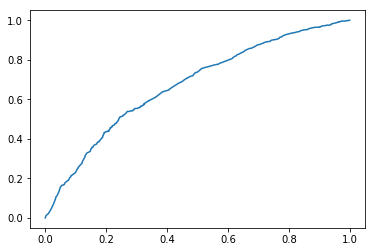

In [18]:
# model evaluation 1: confusion matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_logit).ravel()
print(confusion_matrix(y_test, y_pred_logit))

# model evaluation 2: Accuracy, sensitivity & specificty
print("Accuracy = %s" %((tp+tn)/(tp+fn+tn+fp)))
print("Sensitivity = %s" %(tp/(tp+fn)))
print("Specificity = %s" %(tn/(tn+fp)))

# model evaluation 3: precision & recall & F1_score
print(classification_report(y_test, y_pred_logit))

# model evaluation 4: ROC and AUC
# generate the predicted probability
y_pred_prob = logreg.predict_proba(X_test)[:,1]
print("AUC=", roc_auc_score(y_test, y_pred_prob))

# plot ROC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)

## 2.2 Decision Tree Model

In [19]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth = 3)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)
prediction['tree'] = y_pred_tree

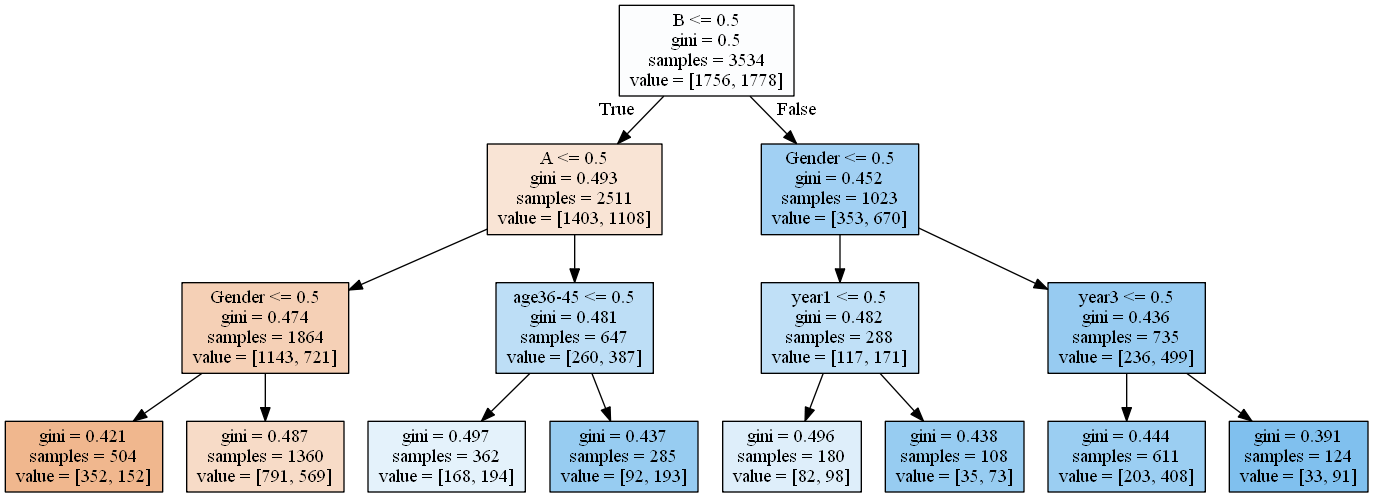

In [20]:
# Print the tree image

import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz

# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return(graph)


graph = print_tree(tree, features=x_columns)
graph.write_png("tree.png")
Image(graph.create_png())


[('Gender', 0.09880433482601414), ('Marital_Status', 0.0), ('age0-17', 0.0), ('age18-25', 0.0), ('age36-45', 0.04825656153886987), ('age46-50', 0.0), ('46-50', 0.0), ('age51-55', 0.0), ('A', 0.32524856479964503), ('B', 0.5031677310778931), ('year0', 0.0), ('year1', 0.01769173054256476), ('year2', 0.0), ('year3', 0.006831077215013163)]


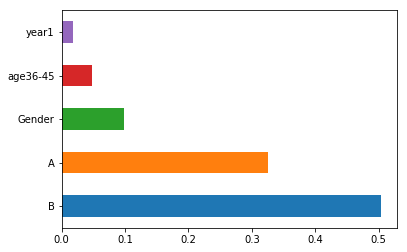

In [21]:
# View a list of the features and their importance scores
print(list(zip(X_train, tree.feature_importances_)))

# plot the important features
feat_importances = pd.Series(tree.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')

### 2.3 Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_features=4, random_state=1)
rfc.fit(X_train, y_train)

y_pred_rfc = rfc.predict(X_test)
prediction['rfc'] = y_pred_rfc

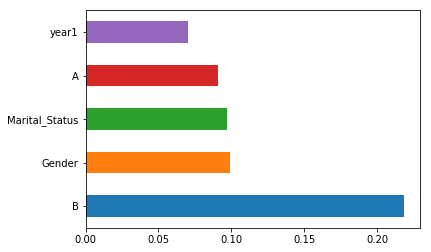

In [23]:
# plot the important features
feat_importances = pd.Series(rfc.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')

### 2.4 KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier  
knn = KNeighborsClassifier(n_neighbors=5)  
knn.fit(X_train, y_train)  

prediction['knn'] = knn.predict(X_test)

### 2.5 Naive Bayes

In [25]:
from sklearn.naive_bayes import GaussianNB
nb1 = GaussianNB()
nb1.fit(X_train, y_train)
prediction['nb'] = nb1.predict(X_test)

### 2.6 Neural Network

In [4]:
# To improve the neural network performance, normalize the input variables

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_nn = scaler.transform(X_train)
X_test_nn = scaler.transform(X_test)

NameError: name 'X_train' is not defined

In [3]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(5,5,5))
mlp.fit(X_train_nn,y_train)

prediction['mlp'] = mlp.predict(X_test)

NameError: name 'X_train_nn' is not defined

### 2.7 Support Vector Machine

In [28]:
from sklearn.svm import SVC

svc = SVC(C= 1.0, kernel='linear')
svc.fit(X_train, y_train)

prediction['svc'] = svc.predict(X_test)

## Compare all models

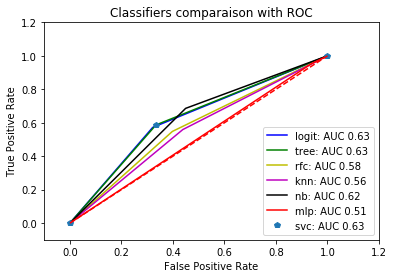

In [29]:
from sklearn.metrics import roc_curve, auc

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k', 'r', 'p']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predicted)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Further Analyses

In [30]:
## Can we predict product category?

sales.Product_Category_1.value_counts()

1     1568
5     1560
8     1335
6      232
11     223
2      209
3      204
4      125
16     120
10      80
15      73
13      47
12      37
7       36
18      23
14      14
9        3
17       2
Name: Product_Category_1, dtype: int64

In [2]:
import numpy as np

# average Up days and Downs Volume
Purchase_by_Productcategory = sales.pivot_table(index="Product_Category_1", values="Purchase", aggfunc=np.sum)
Purchase_by_Productcategory

NameError: name 'sales' is not defined

In [1]:
# average Up days and Downs Volume
Purchase_by_Productcategory_avg = sales.pivot_table(index="Product_Category_1", values="Purchase", aggfunc=np.mean)
Purchase_by_Productcategory_avg

NameError: name 'sales' is not defined